In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [5]:
tf.random.set_seed(23)

In [6]:
img_df = pd.read_csv("photos/image_labels.csv")
img_df.head()

,path,class,label,image_id
0,one_1.jpg,one,0,11
1,one_10.jpg,one,0,11
2,one_11.jpg,one,0,11
3,one_12.jpg,one,0,11
4,one_13.jpg,one,0,11


In [7]:
len(img_df)

992

### Load data

In [8]:
path = "./datasets/original_128"

full_dataset = tf.data.Dataset.load(path)


In [9]:
classes = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", 
           "Alphabet_A", "Alphabet_B", "Alphabet_C", "Alphabet_D", "Alphabet_E", "Alphabet_F", "Alphabet_G", "Alphabet_H", "Alphabet_S", "Alphabet_T", "Alphabet_U", "Alphabet_v", "Alphabet_w", "Alphabet_x", "Alphabet_y", "Alphabet_z", 
           "up_arrow", "down_arrow", "right_arrow", "left_arrow", "Stop", "Bullseye"]

In [10]:
len(full_dataset)

992

In [11]:
full_dataset = full_dataset.shuffle(1000)

In [12]:
val_size = int(0.1*len(full_dataset))
train_size = len(full_dataset) - val_size

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)
val_dataset = val_dataset.take(val_size)

print(len(train_dataset), len(val_dataset))

893 99


In [13]:
#check if all datasets contain all classes
train_labels = []
for image, label in train_dataset:
    train_labels.append(int(label))

print(len(np.unique(train_labels)))

val_labels = []
for image, label in val_dataset:
    val_labels.append(int(label))

print(len(np.unique(val_labels)))

31
31


In [14]:
batch_size = 64

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [15]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### CNN

In [45]:
cnn_model = keras.models.load_model("models/testing/cnn_model.keras", compile=True)

In [46]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 12)      336       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 24)        2616      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 48)       

In [47]:
cnn_model.evaluate(val_dataset)

2/2 [==============================] - 0s 7ms/step - loss: 0.0478 - accuracy: 0.9899


[0.04783888906240463, 0.9898989796638489]

In [48]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [49]:
checkpoint_filepath = 'models/prod/cnn_model.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [50]:
epochs = 50

history = cnn_model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs, 
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


14/14 [==============================] - 15s 926ms/step - loss: 0.1792 - accuracy: 0.9429 - val_loss: 0.1192 - val_accuracy: 0.9697
Epoch 2/50
14/14 [==============================] - 13s 908ms/step - loss: 0.1925 - accuracy: 0.9429 - val_loss: 0.0995 - val_accuracy: 0.9697
Epoch 3/50
14/14 [==============================] - 13s 903ms/step - loss: 0.1627 - accuracy: 0.9384 - val_loss: 0.0588 - val_accuracy: 0.9899
Epoch 4/50
14/14 [==============================] - 13s 911ms/step - loss: 0.1844 - accuracy: 0.9384 - val_loss: 0.0916 - val_accuracy: 0.9798
Epoch 5/50
14/14 [==============================] - 13s 942ms/step - loss: 0.1792 - accuracy: 0.9451 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 6/50
14/14 [==============================] - 13s 927ms/step - loss: 0.1493 - accuracy: 0.9574 - val_loss: 0.0466 - val_accuracy: 1.0000
Epoch 7/50
14/14 [==============================] - 13s 883ms/step - loss: 0.1503 - accuracy: 0.9586 - val_loss: 0.0829 - val_accuracy: 0.9697
Epoch 8/50

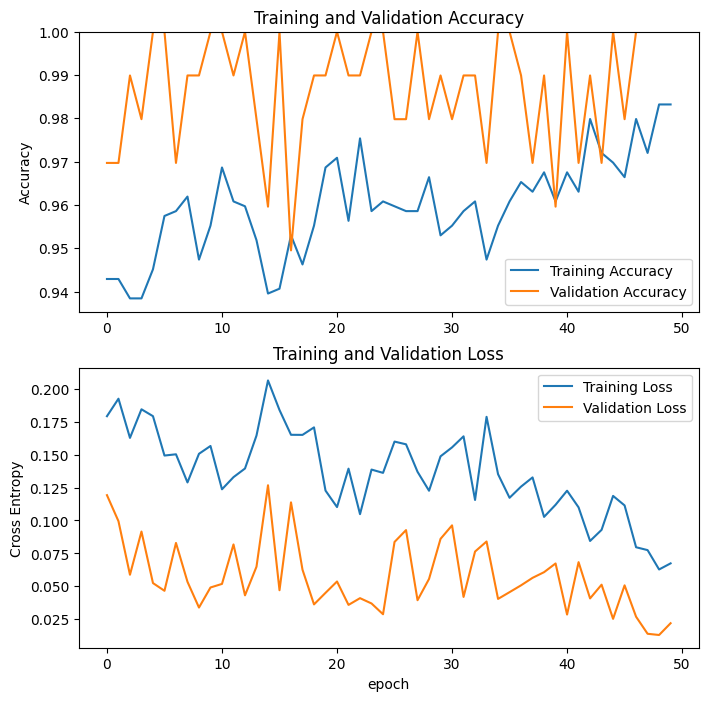

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 0s 2ms/step


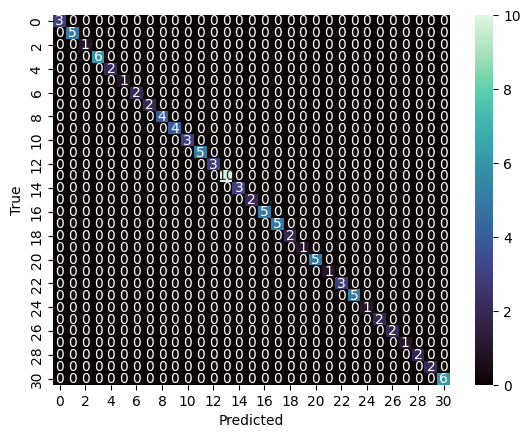

In [53]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

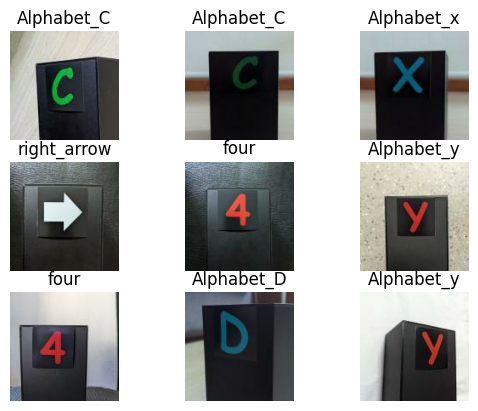

In [54]:
images, labels = next(iter(val_dataset))
preds = cnn_model(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

### CNN depthwise convolution

In [91]:
cnn_model_dw = keras.models.load_model("models/testing/cnn_model_dw.keras", compile=True)

In [92]:
cnn_model_dw.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 separable_conv2d (Separable  (None, 126, 126, 12)     75        
 Conv2D)                                                         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 12)       0         
 2D)                                                             
                                                                 
 separable_conv2d_1 (Separab  (None, 61, 61, 24)       420       
 leConv2D)                                                       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                  

In [93]:
cnn_model_dw.evaluate(val_dataset)

2/2 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 1.0000


[0.04546423628926277, 1.0]

In [94]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [95]:
cnn_model_dw.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [96]:
checkpoint_filepath = 'models/prod/cnn_model_dw.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [97]:
epochs = 50

history = cnn_model_dw.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs, 
  callbacks=[model_checkpoint_callback]
)

Epoch 1/50


14/14 [==============================] - 17s 973ms/step - loss: 0.1478 - accuracy: 0.9563 - val_loss: 0.0557 - val_accuracy: 1.0000
Epoch 2/50
14/14 [==============================] - 13s 919ms/step - loss: 0.1610 - accuracy: 0.9451 - val_loss: 0.0516 - val_accuracy: 0.9899
Epoch 3/50
14/14 [==============================] - 13s 929ms/step - loss: 0.1470 - accuracy: 0.9541 - val_loss: 0.0702 - val_accuracy: 0.9798
Epoch 4/50
14/14 [==============================] - 13s 910ms/step - loss: 0.1442 - accuracy: 0.9474 - val_loss: 0.0617 - val_accuracy: 0.9798
Epoch 5/50
14/14 [==============================] - 13s 924ms/step - loss: 0.1274 - accuracy: 0.9664 - val_loss: 0.0426 - val_accuracy: 0.9899
Epoch 6/50
14/14 [==============================] - 13s 928ms/step - loss: 0.1434 - accuracy: 0.9462 - val_loss: 0.0691 - val_accuracy: 0.9899
Epoch 7/50
14/14 [==============================] - 13s 911ms/step - loss: 0.1340 - accuracy: 0.9653 - val_loss: 0.0583 - val_accuracy: 0.9899
Epoch 8/50

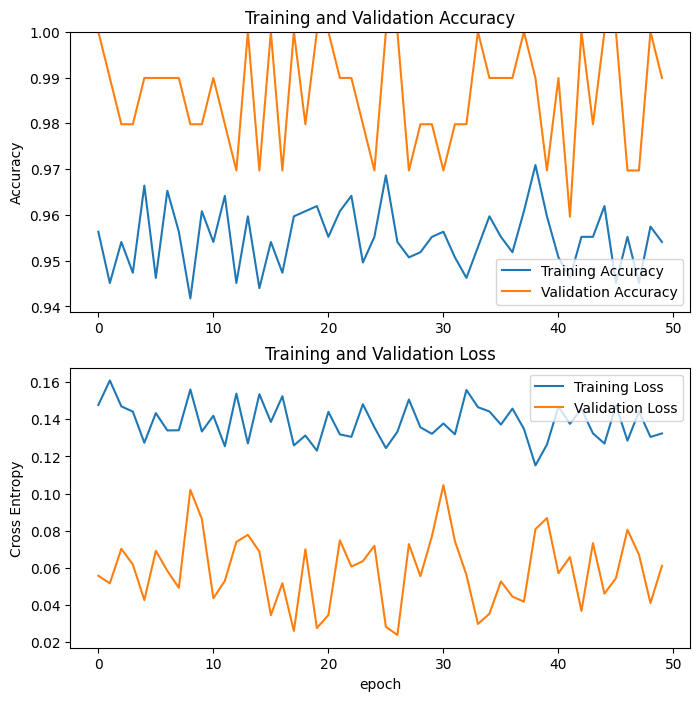

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [103]:
from sklearn.metrics import confusion_matrix

test_labels = []
pred_labels = []
for images, labels in val_dataset:
    test_labels += list(labels.numpy())
    pred_logits = cnn_model_dw.predict(images)
    pred_labels += list(tf.math.argmax(pred_logits, axis=1))

cm = confusion_matrix(test_labels, pred_labels)

2/2 [==============================] - 0s 2ms/step


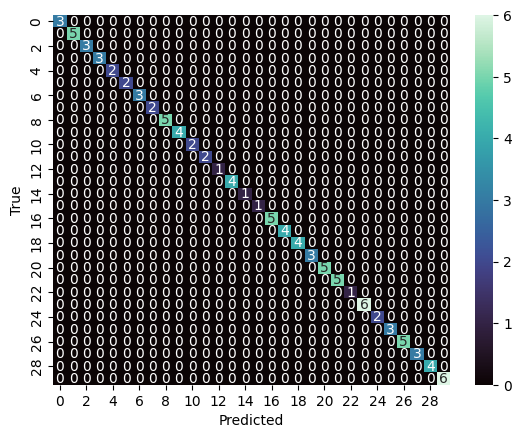

In [104]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

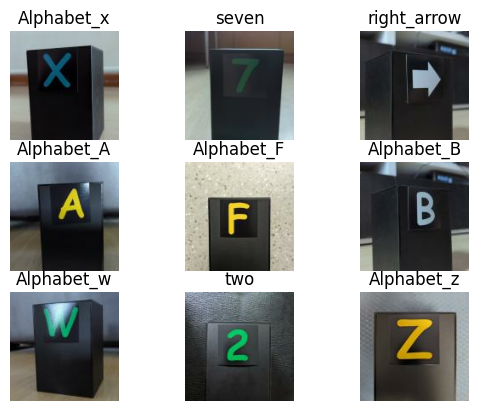

In [105]:
images, labels = next(iter(val_dataset))
preds = cnn_model_dw(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

### Finetune pretrained model

In [67]:
img_shape = (128, 128, 3)

In [68]:
mobnetv3_ft= keras.models.load_model("models/testing/mobnetv3_ft.keras", compile=True)

In [70]:
mobnetv3_ft.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 31)               

In [71]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

In [72]:
checkpoint_filepath = 'models/prod/mobnetv3_ft.keras'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [73]:
mobnetv3_ft.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
epochs = 5

history_mobnet = mobnetv3_ft.fit(train_dataset,
                                epochs=epochs,
                                validation_data=val_dataset, 
                                callbacks=[model_checkpoint_callback])

Epoch 1/5


14/14 [==============================] - 23s 1s/step - loss: 0.0323 - accuracy: 0.9933 - val_loss: 0.0715 - val_accuracy: 0.9697
Epoch 2/5
14/14 [==============================] - 17s 1s/step - loss: 0.0316 - accuracy: 0.9978 - val_loss: 0.0738 - val_accuracy: 0.9899
Epoch 3/5
14/14 [==============================] - 14s 979ms/step - loss: 0.0343 - accuracy: 0.9922 - val_loss: 0.0592 - val_accuracy: 0.9798
Epoch 4/5
14/14 [==============================] - 14s 992ms/step - loss: 0.0403 - accuracy: 0.9922 - val_loss: 0.0509 - val_accuracy: 0.9798
Epoch 5/5
14/14 [==============================] - 18s 1s/step - loss: 0.0290 - accuracy: 0.9989 - val_loss: 0.0411 - val_accuracy: 1.0000


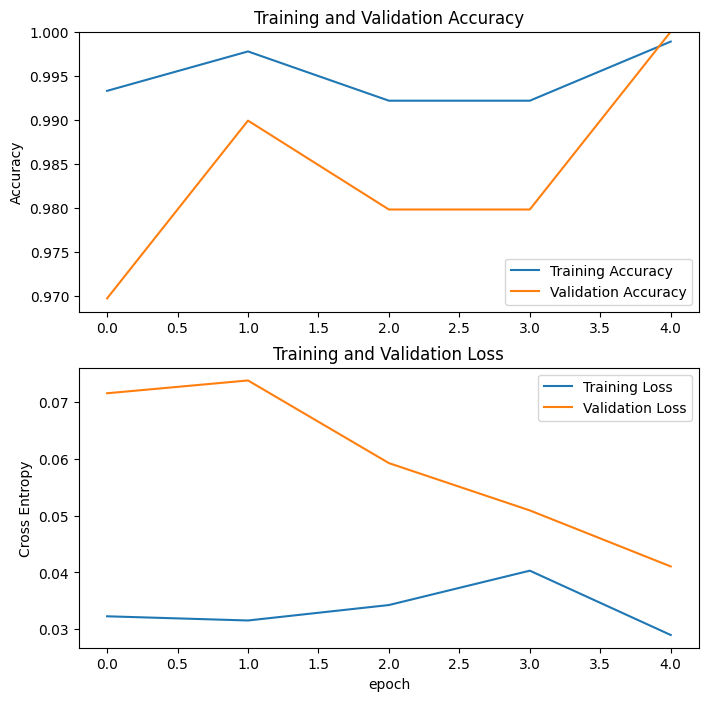

In [75]:
acc = history_mobnet.history['accuracy']
val_acc = history_mobnet.history['val_accuracy']

loss = history_mobnet.history['loss']
val_loss = history_mobnet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

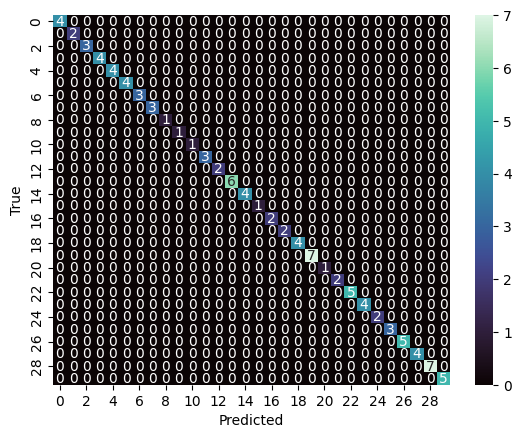

In [80]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt="d", cmap="mako")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

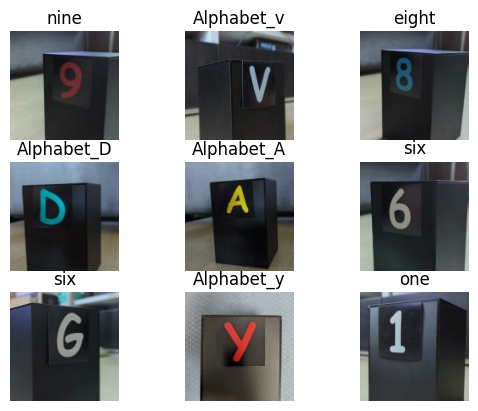

In [81]:
images, labels = next(iter(val_dataset))
preds = mobnetv3_ft(images)
preds = tf.math.argmax(preds, 1).numpy()

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(classes[int(preds[i])])
    plt.axis("off")

##### Testing

In [84]:
import cv2
import os

path = "photos/prod_test"
files_list = [f for f in os.listdir(path) if os.path.isfile(f"{path}/{f}")]
print(files_list)

['PXL_20240205_072313009.jpg', 'PXL_20240205_072356076.jpg', 'PXL_20240205_072421063.jpg', 'PXL_20240205_072512877.jpg', 'PXL_20240205_072532527.jpg', 'PXL_20240205_072553350.jpg', 'PXL_20240205_072639485.jpg', 'PXL_20240205_072712551.jpg', 'PXL_20240205_072723712.jpg']


In [85]:
from PIL import Image

(new_width, new_height) = (128, 128)

for file in files_list:
  with Image.open(f"{path}/{file}") as im:
        width, height = im.size
        if height >= width:
            left = 0
            top = (height-width)/2
            right = width
            bottom = width+(height-width)/2
        else:
            left = (width-height)/2
            top = 0
            right = height+(width-height)/2
            bottom = height
        im_cropped = im.crop((left, top, right, bottom))
        im_resized = im_cropped.resize((new_width, new_height), resample=Image.HAMMING)
        im_resized.save(f"photos/prod_test/resized/{file}")
  
  

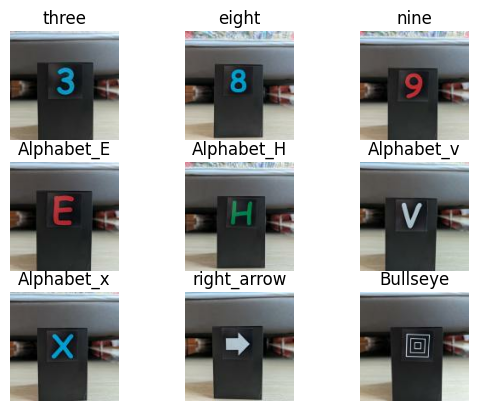

In [106]:
cnn_model= keras.models.load_model("models/prod/cnn_model.keras", compile=True)

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = cnn_model(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(classes[pred])
  plt.axis("off")
  i += 1



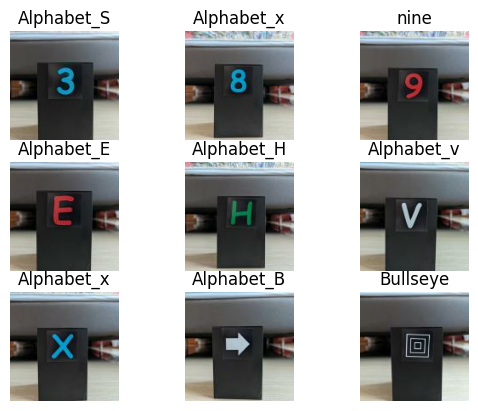

In [111]:
cnn_model_dw= keras.models.load_model("models/prod/cnn_model_dw.keras", compile=True)

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = cnn_model_dw(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(classes[pred])
  plt.axis("off")
  i += 1



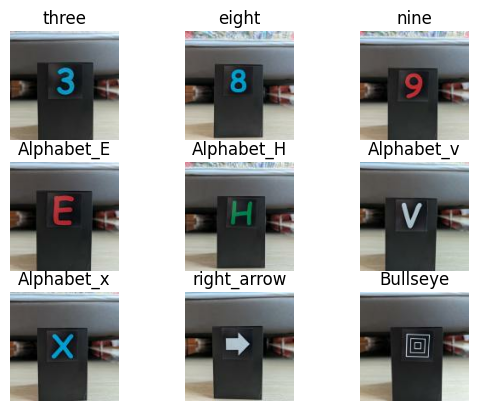

In [112]:

mobnetv3_ft= keras.models.load_model("models/prod/mobnetv3_ft.keras", compile=True)

i = 0
for file in files_list:
  img = tf.image.decode_jpeg(tf.io.read_file(f"photos/prod_test/resized/{file}"), channels=3)/255
  img = tf.cast(img, tf.float32)
  img_batch = np.expand_dims(img, axis=0)
  logits = mobnetv3_ft(img_batch)
  pred = int(tf.math.argmax(logits, axis=1)[0])
  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(classes[pred])
  plt.axis("off")
  i += 1

